# HDDA. Home Assignment 1

In this homework you need to implement your version of the PCA in case you chose the base level, and SparcePCA in case you are a champion. 

- The task consists of three stages. At the first stage, you are invited to demonstrate PCA on a classic dataset. You need to work with and explain why there is a loss of information.

- In the next step, you need to implement an algorithm that matches the level you selected (basic = PCA, champion = SparcePCA), and to test your implementation on a simple synthetic example in which the main components are well identified.

- The third stage is a creative task. You are offered a dataset from the kaggle contest. You are required to solve this task, provide your decisions with comments on why one or another step was taken. After the deadline, we will review your decisions in a discussion format.

## Case 1: Recap

To begin with, we consider the demonstration case of classifying sets that are well separable. We use the function of generating multidimensional blobs from the `sklearn` module.

In [161]:
from sklearn.datasets import make_blobs

In [162]:
X, y = make_blobs(n_samples = 10000, n_features = 5, random_state = 101, centers=4,
                  cluster_std=[5.1, 4.2, 5.3, 2.4],
                  center_box=(-10.0, 10.0),
                  shuffle=True)

Draw the resulting set by using `pyplot` from `matplotlib`

In [163]:
import matplotlib.pyplot as plt

In [164]:
%matplotlib inline

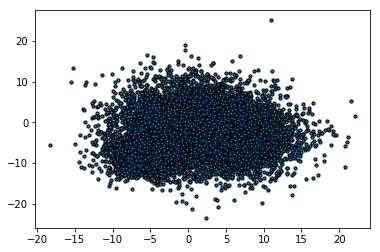

In [165]:
plt.scatter(X[:,0], X[:,1], s=10, edgecolor='k')

gloom...

Okay. Let's see the projections on the first two axes.

In [166]:
# make a color map
color_map = dict(zip([0,1,2,3], ["red", "blue", "green", "yellow"]))

{<matplotlib.collections.PathCollection at 0x7f31cec11470>,
 <matplotlib.collections.PathCollection at 0x7f31cec11eb8>}

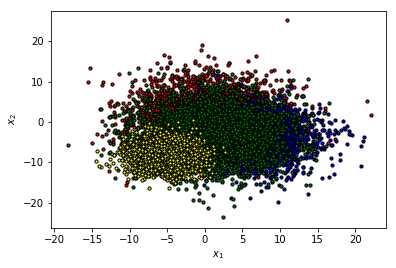

In [167]:
# draw original set by using simple for comprehension
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
{plt.scatter(X[y == k, 0], X[y == k, 1], c=v, s=10, edgecolor='k') for (k,v) in color_map.items()}


Nice! Now let's see what we have with clustering

In [168]:
from sklearn.cluster import KMeans

In [169]:
#Set a 4 KMeans clustering
kmeans_test = KMeans(n_clusters = 4)

In [170]:
#Compute cluster centers and predict cluster indices
X_test = kmeans_test.fit_predict(X)

In [171]:
import numpy as np
# make a color map for predicted cluster indices
kmeans_color_map = dict(zip(np.unique(kmeans_test.labels_), ["red", "blue", "green", "yellow"]))

{<matplotlib.collections.PathCollection at 0x7f31ceb71048>,
 <matplotlib.collections.PathCollection at 0x7f31ceb97cf8>}

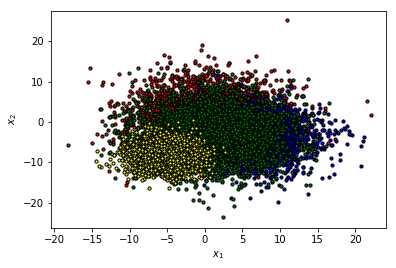

In [172]:
# draw clustered set
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
{plt.scatter(X[y == k, 0], X[y == k, 1], c=v, s=10, edgecolor='k') for (k,v) in kmeans_color_map.items()} 

Ok! What about clustering metrics? Let's see all of them.

In [173]:
from sklearn import metrics

In [174]:
print('ARI: '+str(metrics.adjusted_rand_score(y, kmeans_test.labels_)))
print('AMI: '+str(metrics.adjusted_mutual_info_score(y, kmeans_test.labels_)))
print('Homogenity: '+str(metrics.homogeneity_score(y, kmeans_test.labels_)))
print('Completeness: '+str(metrics.completeness_score(y, kmeans_test.labels_)))
print('V-measure: '+str(metrics.v_measure_score(y, kmeans_test.labels_)))
print('Silhouette: '+str(metrics.silhouette_score(X, kmeans_test.labels_)))

ARI: 0.8246852168354181
AMI: 0.7962457046488808
Homogenity: 0.7963118722897244
Completeness: 0.7974103666643008
V-measure: 0.7968607409010409
Silhouette: 0.3268743642346111


For more info you can use [7 topic of ODS Course](https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering).

Russian version of the article [here](https://habr.com/company/ods/blog/325654/)

Now let's check how much components have influence in terms of explained variance. The [article](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#explained-variance) can help you to realize the concept of explained variance. Here is the support function below: for plotting ` explained variance/principle components` flat. 

In [175]:
# survice function for Explained variance ratio plotting
def plot_explained_variance(X):
    #Calculating Eigenvecors and eigenvalues of Covariance matrix
    mean_vec = np.mean(X, axis=0)
    cov_mat = np.cov(X.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    print(tot)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    print(var_exp)
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
    print(cum_var_exp)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')

To use it properly it would be better to use [Feature Scaling](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)
by using `StandardScaler` from the `sklearn` preprocessing.

In [176]:
from sklearn.preprocessing import StandardScaler

5.000500050004996
[41.08052894804806, 23.350140404817168, 17.877280836181125, 11.057597238818305, 6.634452572135344]
[ 41.08052895  64.43066935  82.30795019  93.36554743 100.        ]


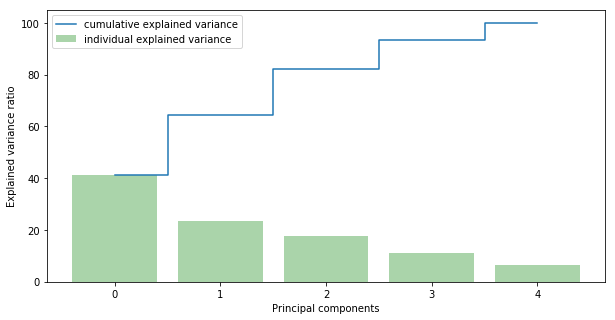

In [177]:
X_std = StandardScaler().fit_transform(X)
plot_explained_variance(X_std)

The plot above clearly shows that most of the variance can be explained by the 4 first principal components. But to see more in detail, let's look at the correlation matrix. To do this, we first wrap the data in the `DataFrame` (`pandas` module) and then use the `heatmap` from `seaborn` module.

In [178]:
import seaborn as sns
import pandas as pd

In [179]:
columns = ['feature_' + str(x) for x in np.arange(1, 7, 1)]
d = {key: values for key, values in zip(columns, X.T)}
data = pd.DataFrame(d)

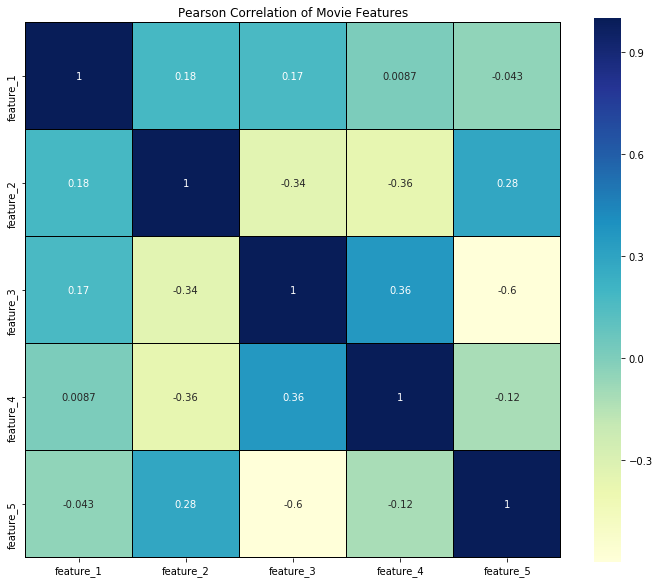

In [180]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Movie Features')
sns.heatmap(data.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

So, it's time to use PCA. Let's try it with 4 components and and see what happens

In [181]:
from sklearn.decomposition import PCA

In [182]:
pca = PCA(n_components=4)
X_transformed = pca.fit_transform(X_std)

{<matplotlib.collections.PathCollection at 0x7f31cea0a1d0>,
 <matplotlib.collections.PathCollection at 0x7f31cea0acf8>}

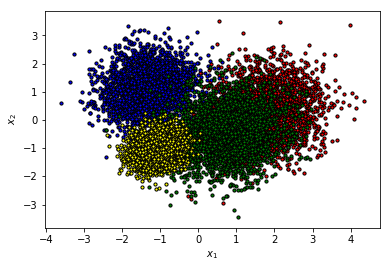

In [183]:
# draw transformed set using simple for comprehension
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
{plt.scatter(X_transformed[y == k, 0], X_transformed[y == k, 1], c=v, s=10, edgecolor='k') for (k,v) in color_map.items()} 

In [184]:
#Set a 4 KMeans clustering
kmeans = KMeans(n_clusters = 4)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_transformed)

print('ARI: '+str(metrics.adjusted_rand_score(y, kmeans.labels_)))
print('AMI: '+str(metrics.adjusted_mutual_info_score(y, kmeans.labels_)))
print('Homogenity: '+str(metrics.homogeneity_score(y, kmeans.labels_)))
print('Completeness: '+str(metrics.completeness_score(y, kmeans.labels_)))
print('V-measure: '+str(metrics.v_measure_score(y, kmeans.labels_)))
print('Silhouette: '+str(metrics.silhouette_score(X, kmeans.labels_)))

ARI: 0.8038804073188663
AMI: 0.7745603920161512
Homogenity: 0.7746336018444214
Completeness: 0.7761285486419428
V-measure: 0.775380354673001
Silhouette: 0.3246539818987651


It is obvious that there was a loss of information and the quality of clustering has greatly decreased. Try to explain this fact.

### Task 1: Explain why in the example above there was a loss of information

The information along the least important principal axis is removed, leaving only the components of the data with the highest variance. 



## Case 2: A Synthetic Example

A synthetic example contains 10 features, each of which is a simple linear combination of three values: $V1, V2, V3$

$$V_1 \sim N(0, 290)$$
$$V_2 \sim N (0, 300)$$
$$V_3 = −0.3 V_1 + 0.925 V_2 + \epsilon, \ \epsilon \sim N(0, 1)$$

You need to find out how much of this data set has the main components, and compare the speed of your PCA implementation (SPCA) and the implementation of the library version.

In [185]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
# The first column contains numbers, so we'll drop it away

df = pd.read_csv("/home/mario/synthetic.csv").drop(['Unnamed: 0'], axis=1)

In [187]:
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-10.300572,-10.223979,-10.261041,-10.298542,-0.907981,-0.871749,-0.858199,-0.869117,2.260210,2.295032
std,290.351225,290.416600,290.447987,290.348275,309.676982,309.679532,309.688980,309.690409,299.690438,299.702929
min,-948.785544,-947.426298,-948.183414,-946.103105,-1050.600486,-1051.590743,-1050.689972,-1052.534237,-981.237523,-979.918814
25%,-208.860156,-207.994619,-208.985917,-209.224097,-215.534522,-215.677995,-215.109818,-215.932351,-209.935685,-208.212333
50%,-13.685264,-12.584181,-12.327687,-12.678418,-0.357133,-0.382485,-0.838992,-0.416611,-0.037262,0.181423
75%,184.409977,185.553442,185.341876,186.585310,213.547165,214.285983,214.444783,214.724167,192.580681,193.193607
max,967.447551,965.439510,965.476957,965.163611,1006.274708,1005.816135,1005.048558,1006.008403,920.426604,919.275054


10.010010010010015
[60.07584141303208, 39.92310484137324, 0.00027513012822424584, 0.0001330273814365153, 0.00012370447597501264, 0.00011665923925232824, 0.00011002412210484531, 0.00010206632431030873, 9.786149549563294e-05, 9.527242789043813e-05]
[ 60.07584141  99.99894625  99.99922138  99.99935441  99.99947812
  99.99959478  99.9997048   99.99980687  99.99990473 100.        ]


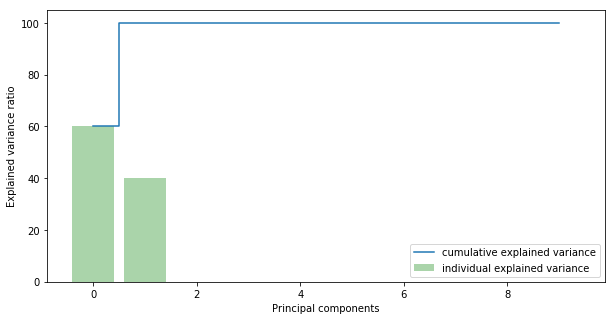

In [188]:
# Do not forget to use the scaling
X_std = StandardScaler().fit_transform(df.values)

# Determine the number of main components.

plot_explained_variance(X_std)



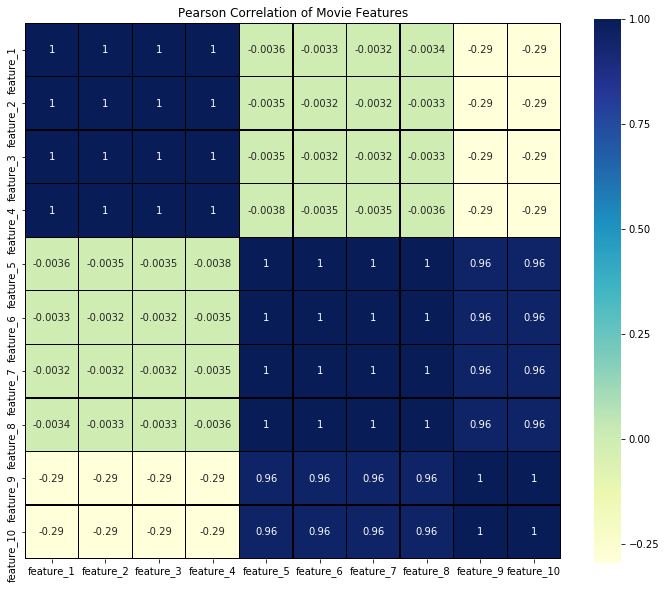

In [189]:
# Check the covariation matrix by using sns.heatmap(...) (optionally)
columns = ['feature_' + str(x) for x in np.arange(1, 12, 1)]
d = {key: values for key, values in zip(columns, X_std.T)}
data = pd.DataFrame(d)

f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Movie Features')
sns.heatmap(data.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

We will test your hypothesis and measure the running time of the library versions of the algorithms

In [190]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

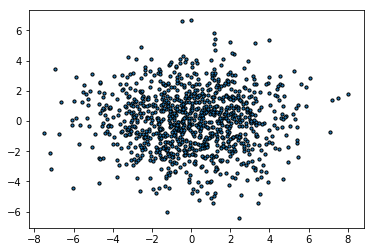

In [191]:
pca = PCA(n_components=2)
x_d = pca.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

In [192]:
%timeit pca.fit_transform(X_std)

2.76 ms ± 47.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


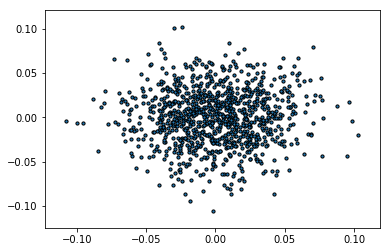

In [193]:
spca = SparsePCA(n_components=2)
x_d = spca.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

In [194]:
%timeit spca.fit_transform(X_std)

374 ms ± 64.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [195]:
X = np.matrix(X_std)
cov = (X.T * X) / X.shape[0]

U, S, V = np.linalg.svd(X_std.T)
print(S)

[77.50860689 63.184733    0.16587047  0.1153375   0.11122251  0.10800891
  0.10489238  0.10102788  0.09892497  0.0976076 ]


### Task 2: Implement you version of PCA (or SPCA) and using template above check it time performance

#### PCA

In [196]:
import math
import random
from functools import partial

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) # number of elements in first row
    return num_rows, num_cols

def sum_of_squares(v):
    #v_1 * v_1 + ... + v_n * v_n
    return dot(v, v)

def magnitude(v):
    return math.sqrt(sum_of_squares(v)) 

def dot(v, w):
    #v_1 * w_1 + ... + v_n * w_n
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def get_row(A, i):
    return A[i] # A[i] is already the ith row

def get_column(A, j):
    return [A_i[j] # jth element of row A_i
        for A_i in A] # for each row A_i

def matrix_product_entry(A, B, i, j):
    return dot(get_row(A, i), get_column(B, j))

def make_matrix(num_rows, num_cols, entry_fn):
    #returns a num_rows x num_cols matrix whose (i,j)th entry is entry_fn(i, j)
    return [[entry_fn(i, j) # given i, create a list
        for j in range(num_cols)] # [entry_fn(i, 0), ... ]
        for i in range(num_rows)] # create one list for each i

def matrix_multiply(A, B):
    n1, k1 = shape(A)
    n2, k2 = shape(B)
    if k1 != n2:
        raise ArithmeticError("incompatible shapes!")
    return make_matrix(n1, k2, partial(matrix_product_entry, A, B))

def vector_as_matrix(v):
    #returns the vector v (represented as a list) as a n x 1 matrix
    return [[v_i] for v_i in v]

def vector_from_matrix(v_as_matrix):
    #returns the n x 1 matrix as a list of values"""
    return [row[0] for row in v_as_matrix]

def matrix_operate(A, v):
    v_as_matrix = vector_as_matrix(v)
    product = matrix_multiply(A, v_as_matrix)
    return vector_from_matrix(product)

def scalar_multiply(c, v):
    #c is a number, v is a vector
    return [c * v_i for v_i in v]

def vector_subtract(v, w):
    #subtracts corresponding elements
    return [v_i - w_i
        for v_i, w_i in zip(v, w)]

def distance(v, w):
    return magnitude(vector_subtract(v, w))

def find_eigenvector(A, tolerance=0.00001):
    guess = [random.random() for __ in A]
    while True:
        result = matrix_operate(A, guess)
        length = magnitude(result)
        next_guess = scalar_multiply(1/length, result)
        if distance(guess, next_guess) < tolerance:
            return next_guess # eigenvector
        guess = next_guess

In [197]:
import numpy as np
from numpy.linalg import norm
 
from random import normalvariate
from math import sqrt
 
        
def svd_1d(X, epsilon=1e-10):

    B = matrix_multiply(X.T, X)

    v = find_eigenvector(B, epsilon)
    return v
    
def svd(A, epsilon=1e-10):
    n, m = shape(A)
    svdSoFar = []
 
    for i in range(m):
        matrixFor1D = A.copy()
 
        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)
            
        
        v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
        u_unnormalized = matrix_operate(A, v)
        sigma = norm(u_unnormalized) 
        u = u_unnormalized / sigma
 
        svdSoFar.append((sigma, u, v))
 
    # transform it into matrices of the right shape
    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
 
    return singularValues, us, vs


In [198]:
singularValues, us, vs = svd(X_std)

# TEST TIME PERFORMANCE OF YOUR PCA
%timeit svd(X_std)

796 ms ± 7.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[77.50860689 63.184733    0.16587047  0.1153375   0.11122251  0.10800891
  0.10489238  0.10102788  0.09892497  0.0976076 ]


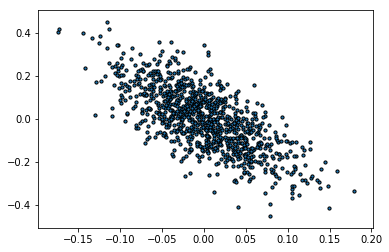

In [199]:
def project_data(X, U, k):  
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

x_d = project_data(X_std, us, 2)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

print(singularValues)

Using numpy

In [200]:
# YOUR IMPLEMENTATION OF PCA (FOR NOVICES)
from numpy.linalg import norm
from random import normalvariate
from math import sqrt

class myPCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        
    def randomUnitVector(self, n):
        unnormalized = [normalvariate(0, 1) for _ in range(n)]
        theNorm = sqrt(sum(x * x for x in unnormalized))
        return [x / theNorm for x in unnormalized]
        
    def svd_1d(self, X, epsilon=1e-10):

        n, m = X.shape
        x = self.randomUnitVector(min(n,m))
        lastV = None
        currentV = x

        if n > m:
            B = np.dot(X.T, X)
        else:
            B = np.dot(X, X.T)

        iterations = 0
        while True:
            iterations += 1
            lastV = currentV
            currentV = np.dot(B, lastV)
            currentV = currentV / norm(currentV)

            if abs(np.dot(currentV, lastV)) > 1 - epsilon:
                return currentV
        
    def fit_transform(self, X, y=None, epsilon=1e-10):
        n, m = X.shape
        svdSoFar = []
 
        for i in range(m):
            matrixFor1D = X.copy()
 
            for singularValue, u, v in svdSoFar[:i]:
                matrixFor1D -= singularValue * np.outer(u, v)
 
            v = self.svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(X, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
 
            svdSoFar.append((sigma, u, v))
 
        # transform it into matrices of the right shape
        singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
 
        return singularValues, us, vs

In [201]:
pca = myPCA(n_components=2)

In [202]:
# TEST TIME PERFORMANCE OF YOUR PCA
%timeit pca.fit_transform(X_std)

35.2 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


[77.50860688 63.18473301  0.16587047  0.1153375   0.11122251  0.10800891
  0.10489238  0.10102788  0.09892497  0.0976076 ]


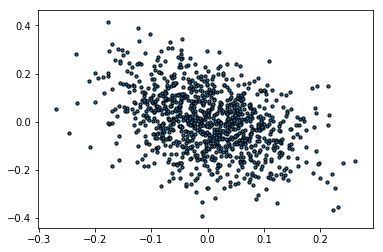

In [203]:
# DRAW RESULTS
singularValues, us, vs = pca.fit_transform(X_std)

x_d = project_data(X_std, us, 2)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

print(singularValues)

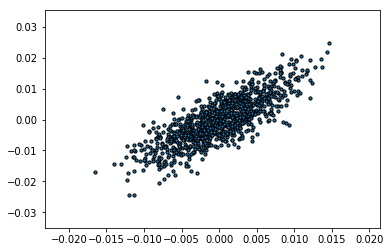

In [204]:
def recover_data(Z, U, k):  
    U_reduced = U[:,:k]
    return np.dot(Z, U_reduced.T)

x_r = recover_data(x_d, us, 2)
plt.scatter(x_r[:,0],x_r[:,1], s=10, edgecolor='k')

## Case 3: Сreative task

I offer your to have a practive with your implementation on [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) Kaggle dataset. 

You need to identify the number of main components and make clustering using Kmeans.

- Preliminary preparation of the dataset: get rid of zero values, transform categorical features.

- Scale the dataset (use StandardScaler or anything you want).

- Identify the number of main components (demonstrate the analysis toolkit).

- Reduce the dimensionality of the space by using your PCA implementation (SPCA).

- Cluster the dataset by Kmeans algo.

In [205]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
df = pd.read_csv("/home/mario/tmdb_5000_movies.csv")

In [207]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [208]:
str_list = [] # empty list to contain columns with strings
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)
#Get to the numeric columns by inversion
num_list = df.columns.difference(str_list)

In [209]:
movie_num = df[num_list]
movie_num.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [210]:
movie_num = movie_num.fillna(value=0, axis=1)

In [211]:
X = movie_num.values

X_std = StandardScaler().fit_transform(X)

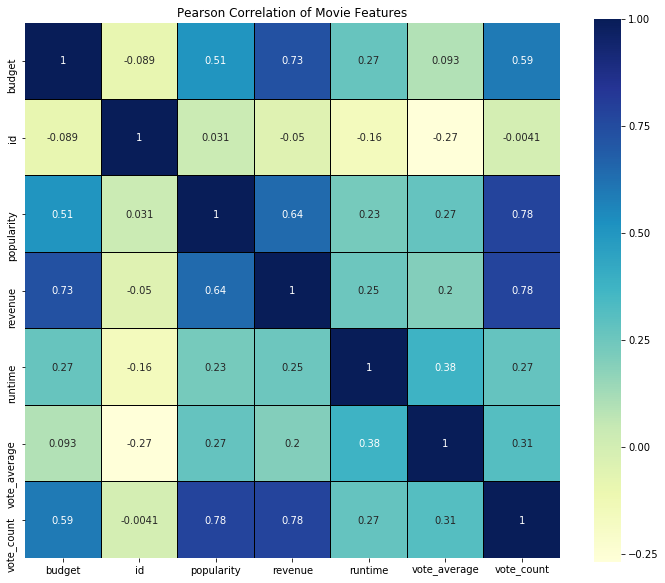

In [212]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Movie Features')
sns.heatmap(movie_num.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

7.001457725947525
[46.795899592001376, 19.246096540257067, 11.967362811496507, 10.138278599809627, 5.889304740097027, 3.681200758939535, 2.281856957398856]
[ 46.79589959  66.04199613  78.00935894  88.14763754  94.03694228
  97.71814304 100.        ]


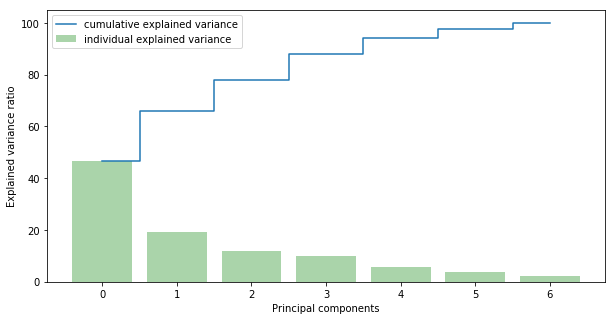

In [213]:
plot_explained_variance(X_std)

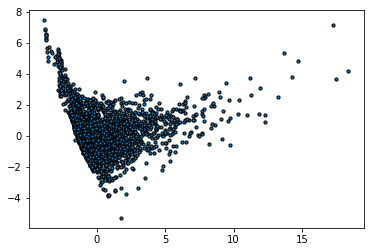

In [214]:
pca1 = PCA(n_components=4)
x_d = pca1.fit_transform(X_std)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

In [215]:
pca = myPCA(n_components=4)

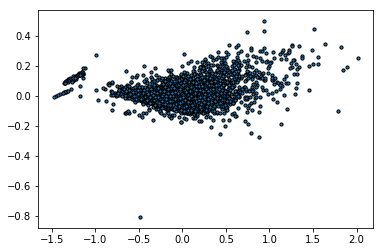

In [216]:
singularValues, us, vs = pca.fit_transform(X_std)

x_d = project_data(X_std, us, 4)
plt.scatter(x_d[:,0],x_d[:,1], s=10, edgecolor='k')

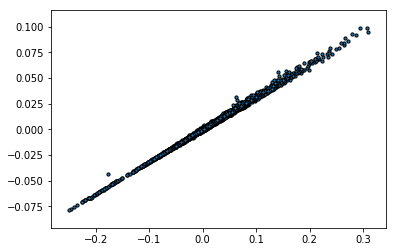

In [217]:
x_r = recover_data(x_d, us, 4)
plt.scatter(x_r[:,0],x_r[:,1], s=10, edgecolor='k')